# Analyzing the Effect of HTTP Port Configuration on Attacker Behavior
### <span style="border-bottom: 2px dashed black; color:#E21833">University of Maryland, College Park</span>
### _HACS202 - Spring 2020 (Group A)_

<div style="width:100%;height:2px;background-color:black;margin-top:25px"></div>

#### Data Analysis + Notebook Author:
Akilesh **Praveen**
#### Groupmates: 
Harlon **Dobson**, Ian **Parks**, Julie **Yang**

This notebook showcases the scraping of data from honeypot logs, the tidying of said data, and the interpretation of this data. This repository also contains the raw scripts used to perform data scraping, with additional debug features included. Find them in the 'scripts' directory.

<div style="width:100%;height:2px;background-color:black;margin-top:25px"></div>

### Table of Contents

0. [Imports](#sec0)
1. [Data Collection](#sec1)
    1. [Supplementary Dataset: Detailed Attack Logs](#detailed)
    2. [Main Dataset: Login Attempts](#logins)
2. [Tidying Data](#sec2)
3. [Interpretation of Results](#sec3)

# Section 0: Imports <a name="sec0"></a>

Libraries and initialization for this project.

In [1]:
import re

## Data structures
import pandas as pd

## Import data visualization packages
import matplotlib.pyplot as plt
%matplotlib inline

# Section 1: Data Collection <a name="sec1"></a>

## Supplementary Dataset: Detailed Attack Logs <a name="detailed"></a>

First, let's extract the data from the `mitm_files` folder. This script is a little involved, but it essentially separates the log into 'attacks'. Each attack is considered begun when the script detects a connection initiated, and each attack is considered ended when the script detecs that the connection is closed. From this, we extract the date & time of the attack, whether a password was used, the IP address of the attacker, and the client that the attacker was using.

This data was then transferred from a list of lists to a dataframe.

_When connections were established and then not closed, that data appeared as ambiguous, and was therefore excluded. Due to the complex and erratic nature of the way event storage was handled in this file, meaningful results in this category were only collected for containers 102 and 103._

### Container 102: HTTPS

In [2]:
def analyze_attack(fp):
    line = fp.readline()

    if not line:
        return None

    # read the first line of an attack
    initial = re.search("([0-9]{4}-[0-9]{2}-[0-9]{2})\s([0-9]{2}:[0-9]{2}:[0-9]{2})\.[0-9]{3}\s-\s\[Debug\]\s\[Connection\]\sAttacker\sconnected:\s(.*)\s\|\sClient\sIdentification:\s(.*)", line)

    if initial:
        my_date = initial.group(1)
        my_time = initial.group(2)
        my_ip = initial.group(3)
        my_client = initial.group(4)

        # number of attempts + whether a password was used or not
        my_attempts = 0
        my_passwords = []

        # this attack continues until we find the 'Attacker closed the connection' line
        end = False
        while(not end):
            nextline = fp.readline()
            found_end = re.search("Attacker\sclosed\sthe\sconnection$",nextline)

            if found_end:
                end = True
                return [my_date, my_time, my_ip, my_client, my_attempts, my_passwords]

            # this line is not the end, we can get data from it
            
            # check to see if password attempts have increased
            attempt_add = re.search("has\sso\sfar\smade", nextline)

            if attempt_add:
                my_attempts += 1

            password_add = re.search("trying\sto\sauthenticate\swith\s\"(.*)\"", nextline)

            if password_add:
                if password_add.group(1) == "none":
                    my_passwords.append(False)
                else:
                    my_passwords.append(True)

            




    else:
        # not a distinct 'attack'- move to next event
        read_until_next(fp)
        return [None, None, None, None, None, None]


def read_until_next(fp):
    line = fp.readline()

    while (line):
        nextgroup = re.search("Attacker\sclosed\sthe\sconnection$",line)

        if nextgroup:
            break
        else:
            line = fp.readline()
            
# use analyze_attack to store all attacks in a list for now


mitm_data_102 = []
mitm_data_103 = []

# open all 3 files and analyze them

with open('../raw_data/mitm_files/mitm_file102', 'r') as fp:
    # fp is now our file pointer to the mitm data file.

    # skip the five lines at the top
    line = fp.readline()
    line = fp.readline()
    line = fp.readline()
    line = fp.readline()
    line = fp.readline()

        
    while line:
        curr = analyze_attack(fp)
        if curr is None:
            break
        else:
            mitm_data_102.append(curr)


            
# move the contents of data to a dataframe
mitm_df_102 = pd.DataFrame(mitm_data_102, columns = ['date', 'time', 'ip_address', 'client_type', 'attempts', 'password_used' ])   
mitm_df_102

,date,time,ip_address,client_type,attempts,password_used
0,2020-05-04,15:14:00,195.3.147.47,SSH-2.0-paramiko_1.8.1,1.0,"[False, True]"
1,2020-05-04,15:14:08,195.3.147.47,SSH-2.0-OpenSSH_5.3,1.0,"[False, True]"
2,2020-05-04,15:14:20,195.3.147.47,SSH-2.0-WinSCP_release_5.1.5,1.0,"[False, True]"
3,2020-05-04,15:16:08,193.105.134.45,SSH-2.0-WinSCP_release_5.7.5,1.0,"[False, True]"
4,2020-05-04,15:16:19,103.89.89.242,SSH-2.0-paramiko_2.7.1,2.0,"[True, False, True]"
5,None,None,None,None,NaN,None
6,2020-05-04,15:19:23,193.105.134.45,SSH-2.0-OpenSSH_5.2,1.0,"[False, True]"
7,2020-05-04,15:22:59,195.3.147.47,SSH-2.0-WinSCP_release_5.1.5,1.0,"[False, True]"
8,2020-05-04,15:24:47,195.3.147.47,SSH-2.0-OpenSSH_3.9p1,1.0,"[False, True]"
9,2020-05-04,15:27:16,195.3.147.47,SSH-2.0-paramiko_1.8.1,1.0,"[False, True]"


### Container 103: Both HTTP and HTTPS

In [3]:
# make a similar dataframe for log 103

with open('../raw_data/mitm_files/mitm_file103', 'r') as fp:
    # fp is now our file pointer to the mitm data file.

    # skip the five lines at the top
    line = fp.readline()
    line = fp.readline()
    line = fp.readline()
    line = fp.readline()
    line = fp.readline()

        
    while line:
        curr = analyze_attack(fp)
        if curr is None:
            break
        else:
            mitm_data_103.append(curr)
            
mitm_df_103 = pd.DataFrame(mitm_data_103, columns = ['date', 'time', 'ip_address', 'client_type', 'attempts', 'password_used' ])   
mitm_df_103

,date,time,ip_address,client_type,attempts,password_used
0,2020-05-04,15:29:40,193.105.134.45,SSH-2.0-Granados-1.0,1.0,"[False, True]"
1,2020-05-04,15:45:47,195.3.147.47,SSH-2.0-paramiko_1.7.7.1,1.0,"[False, True]"
2,2020-05-04,15:56:02,180.214.238.55,SSH-2.0-Go,1.0,"[False, True]"
3,2020-05-04,16:01:08,195.3.147.47,SSH-2.0-OpenSSH_5.2,1.0,"[False, True]"
4,2020-05-04,16:08:14,193.105.134.45,SSH-2.0-libssh_0.5.5,1.0,"[False, True]"
5,2020-05-04,16:31:13,195.3.147.47,SSH-2.0-OpenSSH_6.2,1.0,"[False, True]"
6,2020-05-04,16:45:28,195.3.147.47,SSH-2.0-libssh_0.5.5,1.0,"[False, True]"
7,2020-05-04,16:53:34,195.3.147.47,SSH-2.0-OpenSSH_5.9,1.0,"[False, True]"
8,2020-05-04,16:55:27,193.105.134.45,SSH-2.0-PuTTY_Release_0.64,1.0,"[False, True]"
9,2020-05-04,17:12:14,195.3.147.47,SSH-2.0-Nmap_SSH2_Hostkey,1.0,"[False, True]"


#### Container 101 and Container 104

Unfortunately, there was an error in collecting log data from container 101 that prevented the log file from tracking any data from attempts on the container. As such, we have no data to observe for this particular test case.

Interestingly enough, container 104 had such an erratic Connect and Disconnect pattern that separate events were nigh-indistinguishable. Data from it was not easily convertible into a format similar to containers 102 and 103.

Although not quantitatively definable at this time, this is an interesting observation to make regardless. We can already see this as a clear difference between containers 102, 103, and 104.

## Main Dataset: Login attempts <a name="logins"></a>

We will now look to collect the login attempts for all of our containers, and their details. This can be found in the `raw_data/logins` folder. Since the data was incorruptible for all of these logs, we will be focusing on this for our main, overall data analysis.

Like before, we'll read the data into lists of lists, then proceed to represent them as dataframes.

### Container 101: HTTP

In [4]:
# read and scrape from file for container 101

raw_101_logins = []

with open('../raw_data/logins/101.txt', 'r') as fp:

    line = fp.readline()
    while line:
        line_data = re.search("([0-9]{4}-[0-9]{2}-[0-9]{2})\s([0-9]{2}:[0-9]{2}:[0-9]{2})\.[0-9]*;(.*);password;(.*);(.*)", line)

        if line_data:
            my_date = line_data.group(1)
            my_time = line_data.group(2)
            my_ip = line_data.group(3)
            my_user = line_data.group(4)
            my_password = line_data.group(5)

            raw_101_logins.append([my_date, my_time, my_ip, my_user, my_password])

        else:
            print("---")
            print("error parsing an event.")
            print("event -> ", line)
            print("---")

        line = fp.readline()

login_df_101 = pd.DataFrame(raw_101_logins, columns = ['date', 'time', 'ip_address', 'username', 'password']) 
login_df_101

,date,time,ip_address,username,password
0,2020-05-04,15:16:53,141.98.81.150,admin,admin
1,2020-05-04,15:42:58,141.98.81.138,admin,admin
2,2020-05-04,16:12:52,141.98.81.138,admin,admin
3,2020-05-04,16:45:20,141.98.81.138,admin,admin
4,2020-05-04,17:03:07,141.98.81.138,admin,admin
5,2020-05-04,17:24:40,141.98.81.83,root,admin
6,2020-05-04,17:24:44,141.98.81.84,admin,admin1
7,2020-05-04,17:24:48,141.98.81.99,Administrator,admin
8,2020-05-04,17:24:52,141.98.81.107,root,123456
9,2020-05-04,17:24:58,141.98.81.108,admin,ubnt


### Container 102: HTTPS

In [5]:
# read and scrape from file for container 102

raw_102_logins = []

with open('../raw_data/logins/102.txt', 'r') as fp:

    line = fp.readline()
    while line:
        line_data = re.search("([0-9]{4}-[0-9]{2}-[0-9]{2})\s([0-9]{2}:[0-9]{2}:[0-9]{2})\.[0-9]*;(.*);password;(.*);(.*)", line)

        if line_data:
            my_date = line_data.group(1)
            my_time = line_data.group(2)
            my_ip = line_data.group(3)
            my_user = line_data.group(4)
            my_password = line_data.group(5)

            raw_102_logins.append([my_date, my_time, my_ip, my_user, my_password])

        else:
            print("---")
            print("error parsing an event.")
            print("event -> ", line)
            print("---")

        line = fp.readline()

login_df_102 = pd.DataFrame(raw_102_logins, columns = ['date', 'time', 'ip_address', 'username', 'password']) 
login_df_102

,date,time,ip_address,username,password
0,2020-05-04,15:14:02,195.3.147.47,admin,<Any pass>
1,2020-05-04,15:14:09,195.3.147.47,22,admin
2,2020-05-04,15:14:22,195.3.147.47,admin,12345
3,2020-05-04,15:16:10,193.105.134.45,admin,letmein
4,2020-05-04,15:16:20,103.89.89.242,root,root
5,2020-05-04,15:18:19,193.105.134.45,admin,<No Pass>
6,2020-05-04,15:18:19,193.105.134.45,anonymous,<No pass>
7,2020-05-04,15:19:25,193.105.134.45,admin,admin
8,2020-05-04,15:23:01,195.3.147.47,123321,111111
9,2020-05-04,15:24:49,195.3.147.47,admin,letmein


### Container 103: Both HTTP and HTTPS

In [6]:
# read and scrape from file for container 103

raw_103_logins = []

with open('../raw_data/logins/103.txt', 'r') as fp:

    line = fp.readline()
    while line:
        line_data = re.search("([0-9]{4}-[0-9]{2}-[0-9]{2})\s([0-9]{2}:[0-9]{2}:[0-9]{2})\.[0-9]*;(.*);password;(.*);(.*)", line)

        if line_data:
            my_date = line_data.group(1)
            my_time = line_data.group(2)
            my_ip = line_data.group(3)
            my_user = line_data.group(4)
            my_password = line_data.group(5)

            raw_103_logins.append([my_date, my_time, my_ip, my_user, my_password])

        else:
            # omitting debug code here to yield presentable results
            pass # omit erroneous log data (this file contains some)

        line = fp.readline()

login_df_103 = pd.DataFrame(raw_103_logins, columns = ['date', 'time', 'ip_address', 'username', 'password']) 
login_df_103

,date,time,ip_address,username,password
0,2020-05-04,15:29:41,193.105.134.45,111111,1234
1,2020-05-04,15:45:49,195.3.147.47,3comcso,RIP000
2,2020-05-04,15:56:04,180.214.238.55,root,root
3,2020-05-04,16:01:09,195.3.147.47,123321,11111
4,2020-05-04,16:08:16,193.105.134.45,root,root
5,2020-05-04,16:31:15,195.3.147.47,root,alpine
6,2020-05-04,16:45:30,195.3.147.47,123321,11111
7,2020-05-04,16:53:36,195.3.147.47,111111,1234
8,2020-05-04,16:55:28,193.105.134.45,123321,11111
9,2020-05-04,17:12:16,195.3.147.47,111111,111111


### Container 104: Control

In [7]:
# read and scrape from file for container 104

raw_104_logins = []

with open('../raw_data/logins/104.txt', 'r') as fp:

    line = fp.readline()
    while line:
        line_data = re.search("([0-9]{4}-[0-9]{2}-[0-9]{2})\s([0-9]{2}:[0-9]{2}:[0-9]{2})\.[0-9]*;(.*);password;(.*);(.*)", line)

        if line_data:
            my_date = line_data.group(1)
            my_time = line_data.group(2)
            my_ip = line_data.group(3)
            my_user = line_data.group(4)
            my_password = line_data.group(5)

            raw_104_logins.append([my_date, my_time, my_ip, my_user, my_password])

        else:
            print("---")
            print("error parsing an event.")
            print("event -> ", line)
            print("---")

        line = fp.readline()

login_df_104 = pd.DataFrame(raw_104_logins, columns = ['date', 'time', 'ip_address', 'username', 'password']) 
login_df_104

,date,time,ip_address,username,password
0,2020-05-04,15:27:29,193.105.134.45,test,test
1,2020-05-04,15:29:34,193.105.134.45,admin,guest
2,2020-05-04,15:33:41,193.105.134.45,1234,111111
3,2020-05-04,15:35:46,195.3.147.47,admin,guest
4,2020-05-04,15:47:47,193.105.134.45,admin,ubnt
5,2020-05-04,15:48:00,180.214.238.55,root,root
6,2020-05-04,15:48:18,193.105.134.45,123321,root
7,2020-05-04,16:11:46,193.105.134.45,111111,1234
8,2020-05-04,16:15:11,193.105.134.45,1502,1502
9,2020-05-04,16:33:03,195.3.147.47,admin,guest


# Section 2: Tidying Data <a name="sec2"></a>

In this case, the data we were provided is highly unique in that it is fairly clean. It is organized by date and time, and is already sorted. However, there are still small adjustments we wish to make.

## Main Dataset

### Identifying Use of No Password

I noticed when performing my exploratory data analysis that there were multiple cases when no password was used when attempting to login to our machines. (In other words, the password parameter was left empty'.) However, this was treated differently by our MITM software. We could see results that said 'no pass' or 'any pass' within angle brackets, along with totally blank fields. An easily noticeable example is that of container 102's password field.

In [8]:
login_df_102['password']

0        <Any pass>
1             admin
2             12345
3           letmein
4              root
5         <No Pass>
6         <No pass>
7             admin
8            111111
9           letmein
10              ftp
11           123456
12              123
13         helpdesk
14         12345678
15           client
16        <No pass>
17           shadow
18            admin
19           159753
20        <No Pass>
21        <No pass>
22             root
23           backup
24          service
25             ubnt
26         password
27             1111
28         12345678
29           123123
            ...    
20196          sshd
20197          root
20198        666666
20199        123123
20200          demo
20201          ubnt
20202      admin123
20203          root
20204        159753
20205      1qaz2wsx
20206           101
20207       letmein
20208        backup
20209      password
20210      1qaz2wsx
20211        client
20212     <No pass>
20213     <No Pass>
20214        123123


I'm opting to convert all of these variants to 'None' objects, so we can identify which attempts were passwordless with Python later. I employ regex here to make the operation easier.

In [9]:
def identify_no_password(input_string):
    if not input_string:
        return None
    nopass = re.search('^<no pass>$', input_string, re.IGNORECASE)
    anypass = re.search('^<any pass>$', input_string, re.IGNORECASE)
    if nopass or anypass:
        return None
    else:
        return input_string

login_df_102['password'] = login_df_102['password'].apply(identify_no_password)
login_df_102['password']

0            None
1           admin
2           12345
3         letmein
4            root
5            None
6            None
7           admin
8          111111
9         letmein
10            ftp
11         123456
12            123
13       helpdesk
14       12345678
15         client
16           None
17         shadow
18          admin
19         159753
20           None
21           None
22           root
23         backup
24        service
25           ubnt
26       password
27           1111
28       12345678
29         123123
           ...   
20196        sshd
20197        root
20198      666666
20199      123123
20200        demo
20201        ubnt
20202    admin123
20203        root
20204      159753
20205    1qaz2wsx
20206         101
20207     letmein
20208      backup
20209    password
20210    1qaz2wsx
20211      client
20212        None
20213        None
20214      123123
20215        None
20216    12345678
20217       admin
20218         123
20219    password
20220     

Now, we might as well apply the transformation to the other login attempt datframes.

In [10]:
login_df_101['password'] = login_df_101['password'].apply(identify_no_password)
login_df_103['password'] = login_df_103['password'].apply(identify_no_password)
login_df_104['password'] = login_df_104['password'].apply(identify_no_password)

## Supplementary Dataset

### Removing Empty Entries

One artifact of my data analysis script is that, when an attack isn't open and closed in one occurrence, the event is discarded. (This was done because it was highly difficult to separate these data points into separate events). These results produce empty rows in our dataframe to signify a 'broken event'. I wish to do two things with this measurement. I'm looking to store the number of blank entries in each dataframe (for later data analysis), then remove these blank rows.

In this case, we will be measuring how many 'None' rows exist in the 102 and 103 containers

In [11]:
count_102 = mitm_df_102.count()
count_103 = mitm_df_103.count()

none_count_102 = len(mitm_df_102) - count_102[0]
none_count_103 = len(mitm_df_103) - count_103[0]
print("'None' counts for containers 102 and 103")
print(none_count_102)
print(none_count_103)

'None' counts for containers 102 and 103
887
1011


# Section 3: Interpretation of Results <a name="sec3"></a>

Drawing conclusions from the data we've come up with.

### General Data: Overview

#### Main dataset: Login Attempts

Looking at our main dataset's login attempts, here are some useful statistics.

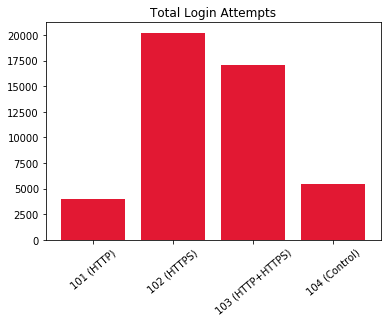

In [12]:
# total overall login attempts
bar = {u'101 (HTTP)':len(login_df_101), u'102 (HTTPS)':len(login_df_102), u'103 (HTTP+HTTPS)':len(login_df_103), u'104 (Control)':len(login_df_104),}

plt.bar(*zip(*bar.items()),color='#E21833')
plt.xticks(rotation='40')
plt.title("Total Login Attempts")
plt.savefig('../plots/total_attempts.png')
plt.show()

We can make two inferences given the above data. First of all, we can see that the presence of HTTPS in a honeypot makes it immensely more attractive in terms of login attempts. It seems that most modern attackers target systems with HTTPS capability. This could potentially be due to the potential for more lucrative data to be stored on HTTPS-enabled machines vs. HTTP enabled machines.

In [13]:
# unique attacker ips per honeypot

# usernames and popularity per honeypot

# passwords and popularity per honeypot

### Day by Day Analysis

### Miscellaneous: Potential Interesting Takeaways

#### General Password Selection - Oddities

We found some odd passwords in use. Aside from the expected defaults such as "admin", "root", "123456789", etc., we also detected attackers trying to login with passwords such as "baseball", "football", and "letmein". We didn't expect such oddities to appear in brute force attempts, and once can only surmise that the inclusion of these attempts could imply that various insecure systems in the past shared these seemingly arbitrary passwords.

We also saw seemingly randomly generated passwords, such as 'D$$C@r3s', which also seemed equally pointless. However, some user and password combinations seemed oddly specific, such as the following. *user:* LIBRSYSISVC, *pass:* fbsn-WVNdHuaE4uS!GT7mEJa. It leads us to believe that these attackers could be exploiting known, albeit niche, vulnerabilities established on smaller, lesser known systems. (E.g. LIBRSYSISVC, although it yielded a fairly fruitless google search, could be the username on a lesser-known type of system that the attacker is specifically looking for).

#### 'None' counts vs. Total Attacks

Analyzing the 'None' counts for our containers vs. the total attack counts yields an interesting result.

In [14]:
print("'None' counts for containers 102 and 103 vs. Total attack counts:")
print(none_count_102, len(mitm_df_102))
print(none_count_103, len(mitm_df_103))
print()

print("Ratios for 102 (HTTPS) vs 103 (HTTP and HTTPS)")
print(none_count_102/len(mitm_df_102))
print(none_count_103/len(mitm_df_103))

'None' counts for containers 102 and 103 vs. Total attack counts:
887 18906
1011 15735

Ratios for 102 (HTTPS) vs 103 (HTTP and HTTPS)
0.046916322860467576
0.06425166825548141


Overall, we see a 4.69% 'chaos factor' in the HTTPS honeypot, and a 6.43% 'chaos factor' in the HTTP+HTTPS honeypot. Although this difference is not substantial, perhaps the erratic nature of the attacks was increased minutely due to the extra presence of the HTTP port open.